# DS3000 Project
## Using Data to Predict Pandemic Vulnerabilities

<b>Authors</b>: Katherine Poissant, Madhur Prashant, Shannen Dawn Louie Espinosa, Anusha Arora

There is no current model that successfully predicts the total number of deaths due to the COVID-19 pandemic based on the vast information that this dataset provides. The reason to provide and predict the total number of deaths using the current information (health, demographics, background) will help not only us but the vast majority in the world to take precautions and measures to reduce the number of deaths, thus making prediction about this a necessity. Therefore, our project will be focussing on predicting this and solving this problem, and using the prediction as a helping  stone to come to conclusions and further solutions/precautions that different individuals can take to reduce the harmful effects of COVID-19.


<b><i>Importing all necessary libraries.

In [1]:
# import libraries
import math
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import LabelEncoder
sns.set_style('darkgrid')

<b><i>Loading data into a Pandas dataframe.

In [2]:
#let's load the data into a dataframe
covid_df = pd.read_csv('owid-covid-data.csv')

#inspect the dimensons
print('There are {} rows and {} columns.'.format(covid_df.shape[0], covid_df.shape[1]))

There are 220343 rows and 67 columns.


<b><i>Removing any duplicate rows.

In [3]:
# drop duplicates and check shape
covid_df.drop_duplicates(inplace=True) #remove any duplicate rows
covid_df.shape

(220343, 67)

<b><i>Checking the frequency of null values in each column.</i></b>
Below we can see all the columns with number of null values printed out. We want to pick columns that have a low number of null values as well as be independant and significant to predict the number of deaths.

In [4]:
pd.options.display.max_rows = 4000
#check the frequency of null values in each column
covid_df.isnull().sum().sort_values(ascending = False)

weekly_icu_admissions_per_million             213216
weekly_icu_admissions                         213216
excess_mortality_cumulative_per_million       212883
excess_mortality_cumulative                   212883
excess_mortality_cumulative_absolute          212883
excess_mortality                              212836
weekly_hosp_admissions                        206151
weekly_hosp_admissions_per_million            206151
icu_patients                                  192288
icu_patients_per_million                      192288
hosp_patients_per_million                     189521
hosp_patients                                 189521
total_boosters_per_hundred                    187407
total_boosters                                187407
new_vaccinations                              169585
people_fully_vaccinated_per_hundred           164082
people_fully_vaccinated                       164082
people_vaccinated                             161324
people_vaccinated_per_hundred                 

<b><i>Filtering columns.</i></b>

> The 2020 paper by Iaccarino et al, 'Age and multimorbidity predict death among COVID-19 patients' focused on the correlation between COVID-19 and factors such as age, hypertension, obesity, COPD, and other health issues and found that age and comorbidities are some of the most useful factors when determining the outcome of COVID-19.

> Although this study was focused on predicting the outcome for a singular patient, this can be expanded to predicting the number of deaths based on the age of the population and the prevalence of some of these comorbidities. If this information could be combined with other information on vaccines at the time, life expectancy, total number of cases, and even hospital information, a relatively accurate model could be created to predict the number of COVID-19 deaths in a given time frame.

> Below you can see the columns pulled out of the dataframe to be used. These were selected because they all had relatively low null value counts and could be helpful in predicting new_deaths_smoothed_per_million. The iso code is the country and each country will give us information about the deaths. Many of the other categories such as stringency_index, median_age, gdp_per_capita, and information about smokers contain information about factors that lead to higher deaths. and thus will help us predict.

In [5]:
# pull columns
covid_df = covid_df[['new_deaths_smoothed_per_million', 'iso_code', 'date', 
                     'new_cases_smoothed_per_million',  
                     'stringency_index', 'reproduction_rate', 'positive_rate', 
                     'population_density', 'median_age', 'cardiovasc_death_rate', 
                     'diabetes_prevalence', 'life_expectancy', 'gdp_per_capita', 
                     'male_smokers', 'female_smokers']]

covid_df.head(10)

,new_deaths_smoothed_per_million,iso_code,date,new_cases_smoothed_per_million,stringency_index,reproduction_rate,positive_rate,population_density,median_age,cardiovasc_death_rate,diabetes_prevalence,life_expectancy,gdp_per_capita,male_smokers,female_smokers
0,NaN,AFG,2/24/2020,NaN,8.33,NaN,NaN,54.422,18.6,597.029,9.59,64.83,1803.987,NaN,NaN
1,NaN,AFG,2/25/2020,NaN,8.33,NaN,NaN,54.422,18.6,597.029,9.59,64.83,1803.987,NaN,NaN
2,NaN,AFG,2/26/2020,NaN,8.33,NaN,NaN,54.422,18.6,597.029,9.59,64.83,1803.987,NaN,NaN
3,NaN,AFG,2/27/2020,NaN,8.33,NaN,NaN,54.422,18.6,597.029,9.59,64.83,1803.987,NaN,NaN
4,NaN,AFG,2/28/2020,NaN,8.33,NaN,NaN,54.422,18.6,597.029,9.59,64.83,1803.987,NaN,NaN
5,NaN,AFG,2/29/2020,0.018,8.33,NaN,NaN,54.422,18.6,597.029,9.59,64.83,1803.987,NaN,NaN
6,NaN,AFG,3/1/2020,0.018,27.78,NaN,NaN,54.422,18.6,597.029,9.59,64.83,1803.987,NaN,NaN
7,NaN,AFG,3/2/2020,0.000,27.78,NaN,NaN,54.422,18.6,597.029,9.59,64.83,1803.987,NaN,NaN
8,NaN,AFG,3/3/2020,0.000,27.78,NaN,NaN,54.422,18.6,597.029,9.59,64.83,1803.987,NaN,NaN
9,NaN,AFG,3/4/2020,0.000,27.78,NaN,NaN,54.422,18.6,597.029,9.59,64.83,1803.987,NaN,NaN


<b><i>Getting non-null counts and data types for each column.</i></b>

In [6]:
# get types for each variable
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220343 entries, 0 to 220342
Data columns (total 15 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   new_deaths_smoothed_per_million  190086 non-null  float64
 1   iso_code                         220343 non-null  object 
 2   date                             220343 non-null  object 
 3   new_cases_smoothed_per_million   208954 non-null  float64
 4   stringency_index                 166246 non-null  float64
 5   reproduction_rate                166135 non-null  float64
 6   positive_rate                    95927 non-null   float64
 7   population_density               195677 non-null  float64
 8   median_age                       181070 non-null  float64
 9   cardiovasc_death_rate            180591 non-null  float64
 10  diabetes_prevalence              189840 non-null  float64
 11  life_expectancy                  205868 non-null  float64
 12  gd

In [7]:
# set data types to be correct for each column
covid_df['iso_code']  = covid_df['iso_code'].astype('string')
covid_df['date']  = covid_df['date'].astype('datetime64')

In [8]:
# only use columns that have new_deaths_smoothed_per_million, which we want to predict
covid_df = covid_df[covid_df['new_deaths_smoothed_per_million'].notna()]

# check data types
covid_df.info()
covid_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 190086 entries, 33 to 220342
Data columns (total 15 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   new_deaths_smoothed_per_million  190086 non-null  float64       
 1   iso_code                         190086 non-null  string        
 2   date                             190086 non-null  datetime64[ns]
 3   new_cases_smoothed_per_million   189860 non-null  float64       
 4   stringency_index                 155074 non-null  float64       
 5   reproduction_rate                163277 non-null  float64       
 6   positive_rate                    90751 non-null   float64       
 7   population_density               173754 non-null  float64       
 8   median_age                       164555 non-null  float64       
 9   cardiovasc_death_rate            163106 non-null  float64       
 10  diabetes_prevalence              170492 non

,new_deaths_smoothed_per_million,iso_code,date,new_cases_smoothed_per_million,stringency_index,reproduction_rate,positive_rate,population_density,median_age,cardiovasc_death_rate,diabetes_prevalence,life_expectancy,gdp_per_capita,male_smokers,female_smokers
33,0.007,AFG,2020-03-28,0.292,67.59,NaN,NaN,54.422,18.6,597.029,9.59,64.83,1803.987,NaN,NaN
34,0.014,AFG,2020-03-29,0.285,67.59,1.51,NaN,54.422,18.6,597.029,9.59,64.83,1803.987,NaN,NaN
35,0.011,AFG,2020-03-30,0.264,67.59,1.51,NaN,54.422,18.6,597.029,9.59,64.83,1803.987,NaN,NaN
36,0.011,AFG,2020-03-31,0.442,67.59,1.52,NaN,54.422,18.6,597.029,9.59,64.83,1803.987,NaN,NaN
37,0.011,AFG,2020-04-01,0.420,67.59,1.52,NaN,54.422,18.6,597.029,9.59,64.83,1803.987,NaN,NaN


Above, the datatypes were fixed to reflect the data in each column and any rows missing the new_deaths_smoothed_per_million value were dropped because they will not help us predict that value.

<b><i>Check null values per row.</i></b>

In [9]:
covid_df.isnull().sum(axis=1).sort_values(ascending = False) #count the frequency of missing values in each row (i.e. how many columns are empty)

150090    11
63678     11
63686     11
63685     11
63684     11
          ..
127646     0
127645     0
127644     0
127643     0
106124     0
Length: 190086, dtype: int64

<b><i>Handling missing data: Deletion.</i></b>

> Any row missing a majority of it's information will not be helpful. We have plenty of rows in this case so we can delete rows missing 4 or more variables

In [10]:
#Handle missing data -- deletion
covid_df = covid_df[covid_df.isnull().sum(axis=1) < 4] #delete rows with 4 or more missing variables (in each row)

covid_df.isnull().sum(axis=1).sort_values(ascending = False) #count the frequency of missing values in each row (i.e. how many columns are empty)

34        3
71439     3
71451     3
71450     3
71449     3
         ..
137165    0
137164    0
137163    0
137162    0
129579    0
Length: 153341, dtype: int64

<b><i>Checking the frequency of null values in each column.</i></b>

In [11]:
#check the frequency of null values in each column
covid_df.isnull().sum()

new_deaths_smoothed_per_million        0
iso_code                               0
date                                   0
new_cases_smoothed_per_million       139
stringency_index                    9203
reproduction_rate                   1918
positive_rate                      65129
population_density                   656
median_age                           987
cardiovasc_death_rate                 51
diabetes_prevalence                    0
life_expectancy                        0
gdp_per_capita                      1895
male_smokers                       27475
female_smokers                     25635
dtype: int64

<b><i>Handling missing data: Imputation by Median</i></b>

> Above, we can see that we still have columns missing a good chunk of their data. In order to fix this, we can use imputation. First, we should try to impuatate based on country. This means that for each country, we should try to fill in missing values based on the median value for that country. If that is not possible, then the value should be filled in with the median of all the countries.

In [12]:
# pull the country codes
iso_code_column = covid_df['iso_code']
# create a unique set of the countries
countries = set(iso_code_column)

# dictionary of columns that have nan values
columns_with_nans = {'new_cases_smoothed_per_million' : 0, 
                     'stringency_index' : 0, 
                     'reproduction_rate' : 0, 
                     'positive_rate' : 0, 
                     'gdp_per_capita': 0,
                     'female_smokers': 0,
                     'male_smokers': 0,
                     'population_density' : 0, 
                     'median_age' : 0, 
                     'cardiovasc_death_rate' : 0, 
                     'diabetes_prevalence' : 0}

# for each column, ge thte column median and add it to the dictionary
for column in columns_with_nans:
        median = covid_df[column].median()
        columns_with_nans[column] = median
        
# for each country
for country in countries:
    # get the current country data
    curr_country_df = covid_df[covid_df['iso_code'] == country]
    #for each column with nans
    for column in columns_with_nans:
        # get the median for the column for the specific country
        curr_median = curr_country_df[column].median()
        # if that median doesn't exist, set the value to the overall column median
        if math.isnan(curr_median):
            covid_df.loc[covid_df['iso_code'] == country, column] = columns_with_nans[column]
        # else set it to the coulmn median for that country
        else :
            covid_df.loc[covid_df['iso_code'] == country, column] = covid_df.loc[covid_df['iso_code'] == country, column].fillna(curr_median)

# check no null values
covid_df.isnull().sum()   

new_deaths_smoothed_per_million    0
iso_code                           0
date                               0
new_cases_smoothed_per_million     0
stringency_index                   0
reproduction_rate                  0
positive_rate                      0
population_density                 0
median_age                         0
cardiovasc_death_rate              0
diabetes_prevalence                0
life_expectancy                    0
gdp_per_capita                     0
male_smokers                       0
female_smokers                     0
dtype: int64

In [13]:
# create days since outbreak column
covid_df['days since outbreak'] = (covid_df['date'] - covid_df.sort_values(by = 'date').iloc[0]['date']).dt.days

covid_df.head()

,new_deaths_smoothed_per_million,iso_code,date,new_cases_smoothed_per_million,stringency_index,reproduction_rate,positive_rate,population_density,median_age,cardiovasc_death_rate,diabetes_prevalence,life_expectancy,gdp_per_capita,male_smokers,female_smokers,days since outbreak
34,0.014,AFG,2020-03-29,0.285,67.59,1.51,0.0917,54.422,18.6,597.029,9.59,64.83,1803.987,31.4,6.2,62
35,0.011,AFG,2020-03-30,0.264,67.59,1.51,0.0917,54.422,18.6,597.029,9.59,64.83,1803.987,31.4,6.2,63
36,0.011,AFG,2020-03-31,0.442,67.59,1.52,0.0917,54.422,18.6,597.029,9.59,64.83,1803.987,31.4,6.2,64
37,0.011,AFG,2020-04-01,0.420,67.59,1.52,0.0917,54.422,18.6,597.029,9.59,64.83,1803.987,31.4,6.2,65
38,0.007,AFG,2020-04-02,0.552,67.59,1.51,0.0917,54.422,18.6,597.029,9.59,64.83,1803.987,31.4,6.2,66


Above, we added in a new column that shows the days since the outbreak. This will allow us to use the date information in our models since models do not like to use date types.

## Case Study: USA

In [14]:
# pull data speicifcally for usa
usa_covid_df = covid_df[covid_df['iso_code'] == 'USA']
usa_covid_df.head()

,new_deaths_smoothed_per_million,iso_code,date,new_cases_smoothed_per_million,stringency_index,reproduction_rate,positive_rate,population_density,median_age,cardiovasc_death_rate,diabetes_prevalence,life_expectancy,gdp_per_capita,male_smokers,female_smokers,days since outbreak
207746,0.005,USA,2020-03-05,0.071,20.37,3.59,0.072,35.608,38.3,151.089,10.79,78.86,54225.446,24.6,19.1,38
207747,0.006,USA,2020-03-06,0.093,20.37,3.55,0.072,35.608,38.3,151.089,10.79,78.86,54225.446,24.6,19.1,39
207748,0.007,USA,2020-03-07,0.160,20.37,3.56,0.107,35.608,38.3,151.089,10.79,78.86,54225.446,24.6,19.1,40
207749,0.008,USA,2020-03-08,0.206,20.37,3.46,0.111,35.608,38.3,151.089,10.79,78.86,54225.446,24.6,19.1,41
207750,0.007,USA,2020-03-09,0.228,20.37,3.35,0.109,35.608,38.3,151.089,10.79,78.86,54225.446,24.6,19.1,42


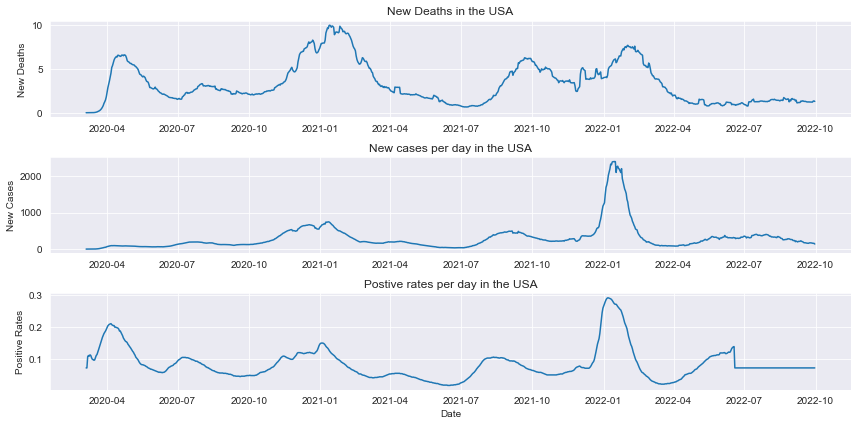

In [15]:
# create plot
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (12, 6))

# pull desired data from dataframe
usa_dates = usa_covid_df['date']
usa_deaths = usa_covid_df['new_deaths_smoothed_per_million']
usa_cases = usa_covid_df['new_cases_smoothed_per_million']
usa_rates = usa_covid_df['positive_rate']

# plot Total Death Count in the USA
ax[0].plot(usa_dates, usa_deaths)
ax[0].set(ylabel = 'New Deaths',
          title = 'New Deaths in the USA')

# plot New cases per day in the USA
ax[1].plot(usa_dates, usa_cases)
ax[1].set(ylabel = 'New Cases',
          title = 'New cases per day in the USA')

# plot Postive rates per day in the USA
ax[2].plot(usa_dates, usa_rates)
ax[2].set(xlabel = 'Date',
          ylabel = 'Positive Rates',
          title = 'Postive rates per day in the USA')

plt.tight_layout(pad=1)

Above, we did a study on USA data. We can see above new deaths, new cases, and positive rates were all plotted vs the date. We can see that there is a correlation between new deaths and the other two. This proves that these two features will be very important when predicting new deaths. 

# Machine Learning Techniques

In [16]:
#divide the data into the input 'X' and the labels 'y'
X = covid_df[['iso_code', 'new_cases_smoothed_per_million',
              'stringency_index', 'reproduction_rate', 'positive_rate',
              'population_density', 'median_age', 'cardiovasc_death_rate', 
              'diabetes_prevalence', 'life_expectancy', 'days since outbreak', 
              'gdp_per_capita', 'male_smokers', 'female_smokers']] #the observations
y = covid_df[['new_deaths_smoothed_per_million']] #the label

# encode iso_code
X = pd.get_dummies(X, columns=['iso_code'])

# set correct shape for y
y = y.to_numpy()
y = y.reshape(y.shape[0], )


#split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, # input features
                                                    y, # labels
                                                    test_size=0.3, # 30% of data for testing
                                                    random_state=7) #set random seed

In [17]:
# make copies 
X_train = X_train.copy()
X_test  = X_test.copy()

In [18]:
# check dataframe
X_train.head()

,new_cases_smoothed_per_million,stringency_index,reproduction_rate,positive_rate,population_density,median_age,cardiovasc_death_rate,diabetes_prevalence,life_expectancy,days since outbreak,...,iso_code_UZB,iso_code_VCT,iso_code_VEN,iso_code_VNM,iso_code_VUT,iso_code_WSM,iso_code_YEM,iso_code_ZAF,iso_code_ZMB,iso_code_ZWE
29536,5.132,35.19,0.22,0.0585,81.347,32.4,201.285,12.79,75.86,347,...,0,0,0,0,0,0,0,0,0,0
30908,239.372,21.30,0.85,0.1283,65.180,44.7,424.688,5.81,75.05,782,...,0,0,0,0,0,0,0,0,0,0
180172,417.299,39.35,1.01,0.1930,102.619,44.5,153.493,7.25,81.32,608,...,0,0,0,0,0,0,0,0,0,0
3719,0.291,45.32,1.51,0.0585,17.348,29.1,278.364,6.73,76.88,888,...,0,0,0,0,0,0,0,0,0,0
142128,1.543,13.89,1.34,0.0292,51.667,27.3,137.016,11.47,74.48,473,...,0,0,0,0,0,0,0,0,0,0


In [19]:
#normalize the numeric features for training
scaler = StandardScaler()
scaler.fit(X_train[['new_cases_smoothed_per_million',
                    'stringency_index', 'reproduction_rate', 'positive_rate', 
                    'population_density', 'median_age', 'cardiovasc_death_rate',
                    'diabetes_prevalence', 'life_expectancy', 'days since outbreak', 
                    'gdp_per_capita', 'male_smokers', 'female_smokers']])

X_train[['new_cases_smoothed_per_million', 
         'stringency_index', 
         'reproduction_rate', 
         'positive_rate', 
         'population_density', 
         'median_age', 
         'cardiovasc_death_rate', 
         'diabetes_prevalence', 
         'life_expectancy', 
         'days since outbreak', 
         'gdp_per_capita', 
         'male_smokers', 
         'female_smokers']] = scaler.transform(X_train[['new_cases_smoothed_per_million', 
                                                         'stringency_index', 
                                                         'reproduction_rate', 
                                                         'positive_rate', 
                                                         'population_density', 
                                                         'median_age', 
                                                         'cardiovasc_death_rate', 
                                                         'diabetes_prevalence', 
                                                         'life_expectancy', 
                                                         'days since outbreak', 
                                                         'gdp_per_capita', 
                                                         'male_smokers', 
                                                         'female_smokers']]) #scale the training data

X_train.head()

,new_cases_smoothed_per_million,stringency_index,reproduction_rate,positive_rate,population_density,median_age,cardiovasc_death_rate,diabetes_prevalence,life_expectancy,days since outbreak,...,iso_code_UZB,iso_code_VCT,iso_code_VEN,iso_code_VNM,iso_code_VUT,iso_code_WSM,iso_code_YEM,iso_code_ZAF,iso_code_ZMB,iso_code_ZWE
29536,-0.354696,-0.648321,-1.995063,-0.261986,-0.188197,0.193949,-0.470360,1.311003,0.392191,-0.691957,...,0,0,0,0,0,0,0,0,0,0
30908,0.130926,-1.293339,-0.289356,0.464465,-0.212799,1.546200,1.391844,-0.495062,0.283964,0.968200,...,0,0,0,0,0,0,0,0,0,0
180172,0.499801,-0.455141,0.143840,1.137837,-0.155826,1.524213,-0.868736,-0.122464,1.121726,0.304137,...,0,0,0,0,0,0,0,0,0,0
3719,-0.364732,-0.177909,1.497575,-0.261986,-0.285587,-0.168850,0.172142,-0.257014,0.528478,1.372745,...,0,0,0,0,0,0,0,0,0,0
142128,-0.362136,-1.637441,1.037305,-0.566929,-0.233362,-0.366741,-1.006082,0.969455,0.207803,-0.211084,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# normalize the numeric features for testing
X_test[['new_cases_smoothed_per_million', 
         'stringency_index', 
         'reproduction_rate', 
         'positive_rate', 
         'population_density', 
         'median_age', 
         'cardiovasc_death_rate', 
         'diabetes_prevalence', 
         'life_expectancy', 
         'days since outbreak', 
         'gdp_per_capita', 
         'male_smokers', 
         'female_smokers']] = scaler.transform(X_test[['new_cases_smoothed_per_million', 
                                                         'stringency_index', 
                                                         'reproduction_rate', 
                                                         'positive_rate', 
                                                         'population_density', 
                                                         'median_age', 
                                                         'cardiovasc_death_rate', 
                                                         'diabetes_prevalence', 
                                                         'life_expectancy', 
                                                         'days since outbreak', 
                                                         'gdp_per_capita', 
                                                         'male_smokers', 
                                                         'female_smokers']]) #scale the training data

X_test.head()

,new_cases_smoothed_per_million,stringency_index,reproduction_rate,positive_rate,population_density,median_age,cardiovasc_death_rate,diabetes_prevalence,life_expectancy,days since outbreak,...,iso_code_UZB,iso_code_VCT,iso_code_VEN,iso_code_VNM,iso_code_VUT,iso_code_WSM,iso_code_YEM,iso_code_ZAF,iso_code_ZMB,iso_code_ZWE
152057,-0.328329,0.880402,0.089690,-0.116280,0.076930,-0.784510,1.378032,0.162159,-0.755556,0.151479,...,0,0,0,0,0,0,0,0,0,0
29904,-0.250958,0.073318,1.605874,-0.261986,-0.188197,0.193949,-0.470360,1.311003,0.392191,0.712498,...,0,0,0,0,0,0,0,0,0,0
95795,0.141829,-0.417062,0.766558,-0.246375,-0.205656,0.886565,-1.094081,-1.149696,1.252668,0.059884,...,0,0,0,0,0,0,0,0,0,0
126068,-0.345377,0.039419,0.631184,-0.611682,-0.305459,-1.136315,-0.211439,-1.372220,-1.069550,0.422447,...,0,0,0,0,0,0,0,0,0,0
185357,-0.359081,-0.132400,-0.505954,-0.633538,-0.188197,-1.257248,0.192239,0.700356,-2.014203,-0.741571,...,0,0,0,0,0,0,0,0,0,0


Above, we split our data into training and test sets and normalized all of our numerical data. These are the final steps before running the models.

## Algorithm 1: Linear Regression

In [21]:
# create lr model and fit to training data
lr_model = LinearRegression(fit_intercept=True)
lr_model = lr_model.fit(X_train, y_train)

# make predictions
y_pred = lr_model.predict(X_test)

#find and print mse
mse = mean_squared_error(y_test, y_pred)
print('The mse of the model is: {}'.format(round(mse, 2)))

The mse of the model is: 4.52


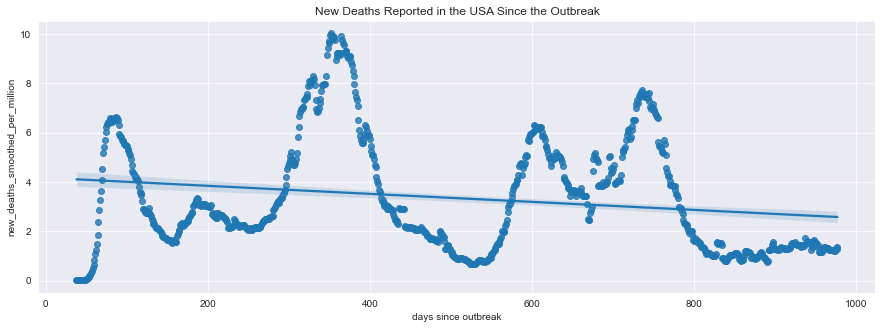

In [43]:
fig = plt.figure(figsize=(15,5))
sns.regplot(data = usa_covid_df, x = 'days since outbreak', y = 'new_deaths_smoothed_per_million')
plt.title("New Deaths Reported in the USA Since the Outbreak")
plt.show()

Above, we ran a linear regression model. We can see here that the mse is 4.52. When considering that we are predicting deaths per million, this is a pretty bad model. Looking at the graph above for new deaths, we can see why linear regression doesn't work. The graph is not very linear so the linear regression model is outputting a line close to the average and results in a large mse. We chose to use mse because it is the typical accuracy used in regression.

## Algorithm 2: K-Nearest Neighbors

In [23]:
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor
from sklearn.neighbors import KNeighborsRegressor

n_values = np.arange(1, 10)
mse_values = []

for n in n_values:
    # create knn model and fit to training data
    neigh = KNeighborsRegressor(n_neighbors=n)
    neigh.fit(X_train, y_train)

    # make predictions
    y_pred = neigh.predict(X_test)

    #find mse
    mse = mean_squared_error(y_test, y_pred)
    mse_values.append(mse)
    
print(mse_values)
print('The best model has n_neighbors = {}'.format(mse_values.index(min(mse_values)) + 1))
print('The mse of the model is: {}'.format(round(min(mse_values), 2)))

[0.2046307497554507, 0.19123113765406602, 0.19633938686848926, 0.22167167812017693, 0.2515727474755994, 0.28001152540776325, 0.30514590341801134, 0.3346869466430858, 0.36504159934738556]
The best model has n_neighbors = 2
The mse of the model is: 0.19


Above, we ran a k-nearrest neighbors model for regression. We can see here that the mse is 0.19. When considering that we are predicting deaths per million, this is a pretty good model, and much better than our linear regression model. We also tuned the hyperparameter by trying n_neighbors values from 1 to 9 and found that the best value was 2 and had a mse of 0.19. We can see that having a smaller n_neighbors works better.

## Algorithm 3: Random Forest Regressor

In [24]:
# create the model
rf = RandomForestRegressor(random_state=7)

# fit the model
rf.fit(X_train, y_train)

#predict the labels for the test set
y_pred   = rf.predict(X_test)

# calculate mean squared error
mse = mean_squared_error(y_test, y_pred)

# Evaluate the Predictions
print('The mse of the model is: {}'.format(round(mse, 2)))

The mse of the model is: 0.13


In [25]:
# print feature importance
print(rf.feature_importances_)

[3.99771322e-01 4.03077881e-02 7.82830063e-02 2.40670376e-02
 2.33028790e-02 3.90080369e-02 5.01084385e-02 2.24949224e-02
 1.57526008e-02 1.61428467e-01 3.10187934e-02 1.10375733e-02
 2.31686888e-02 1.41232999e-05 3.46133569e-07 7.21001503e-05
 4.68209058e-04 6.67895755e-06 4.90877179e-05 1.69647563e-04
 2.10750537e-04 1.95507420e-05 1.50472593e-04 1.49879262e-05
 1.60084208e-07 3.71140690e-04 2.89265510e-07 4.82088541e-08
 4.74275389e-07 4.65303975e-03 5.98070078e-05 1.26367151e-03
 4.83530060e-03 3.43431150e-04 1.70835969e-04 2.82437997e-04
 2.76734448e-04 1.24032699e-03 7.40457380e-05 6.20249018e-06
 2.08641092e-04 1.75982616e-07 3.07193453e-05 7.96604935e-05
 6.05908508e-05 2.15415095e-09 1.72445281e-07 5.59357832e-07
 2.78588079e-08 3.91854955e-07 2.84280189e-04 6.82953720e-05
 1.90440674e-05 4.96510329e-05 1.09854465e-04 6.50003543e-05
 1.32054861e-04 3.47797740e-05 3.16140375e-06 1.96061541e-06
 1.18864255e-04 1.19362820e-05 2.82744874e-06 3.09385715e-04
 1.06381948e-05 6.980924

In [26]:
# create the model
rf = RandomForestRegressor(random_state=7, n_estimators=50)

# fit the model
rf.fit(X_train, y_train)

#predict the labels for the test set
y_pred   = rf.predict(X_test)

# calculate mean squared error
mse = mean_squared_error(y_test, y_pred)

# Evaluate the Predictions
print('The mse of the model is: {}'.format(round(mse, 2)))

The mse of the model is: 0.14


In [27]:
# create the model
rf = RandomForestRegressor(random_state=7, n_estimators=150)

# fit the model
rf.fit(X_train, y_train)

#predict the labels for the test set
y_pred   = rf.predict(X_test)

# calculate mean squared error
mse = mean_squared_error(y_test, y_pred)

# Evaluate the Predictions
print('The mse of the model is: {}'.format(round(mse, 2)))

The mse of the model is: 0.13


In [28]:
# create the model
rf = RandomForestRegressor(random_state=7, n_estimators=200)

# fit the model
rf.fit(X_train, y_train)

#predict the labels for the test set
y_pred   = rf.predict(X_test)

# calculate mean squared error
mse = mean_squared_error(y_test, y_pred)

# Evaluate the Predictions
print('The mse of the model is: {}'.format(round(mse, 2)))

The mse of the model is: 0.13


Above, we ran a random forrests model for regression. We can see here that the mse is 0.13. When considering that we are predicting deaths per million, this is a pretty good model, and actually even better than our k-nearest neighbors model. We also tuned the hyperparameter by trying n_estimators values 100, 50, 150, and 200 and found that the n_estimators of 100, 150, and 200 had an mse of 0.13 and 50 had a mse of 0.14. This shows that n_estimators does not have much of an impact on this model. This was the best model for the full dataset and shows that if we had new data, we would be able to predict the deaths fairly accurately.

## Algorithm 4: Previous Algorithms & SVM on Smaller Dataset

In [29]:
# pull data speicifcally for usa
usa_covid_df = covid_df[covid_df['iso_code'] == 'USA']

In [30]:
#divide the data into the input 'X' and the labels 'y'
X = usa_covid_df[['iso_code', 'new_cases_smoothed_per_million',
              'stringency_index', 'reproduction_rate', 'positive_rate',
              'population_density', 'median_age', 'cardiovasc_death_rate', 
              'diabetes_prevalence', 'life_expectancy', 'days since outbreak', 
              'gdp_per_capita', 'male_smokers', 'female_smokers']] #the observations
y = usa_covid_df[['new_deaths_smoothed_per_million']] #the label

# encode iso_code
X = pd.get_dummies(X, columns=['iso_code'])

# set correct shape for y
y = y.to_numpy()
y = y.reshape(y.shape[0], )


#split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, # input features
                                                    y, # labels
                                                    test_size=0.3, # 30% of data for testing
                                                    random_state=7) #set random seed

In [31]:
# make copies 
X_train = X_train.copy()
X_test  = X_test.copy()

In [32]:
#normalize the numeric features for training
scaler = StandardScaler()
scaler.fit(X_train[['new_cases_smoothed_per_million',
                    'stringency_index', 'reproduction_rate', 'positive_rate', 
                    'population_density', 'median_age', 'cardiovasc_death_rate',
                    'diabetes_prevalence', 'life_expectancy', 'days since outbreak', 
                    'gdp_per_capita', 'male_smokers', 'female_smokers']])

X_train[['new_cases_smoothed_per_million', 
         'stringency_index', 
         'reproduction_rate', 
         'positive_rate', 
         'population_density', 
         'median_age', 
         'cardiovasc_death_rate', 
         'diabetes_prevalence', 
         'life_expectancy', 
         'days since outbreak', 
         'gdp_per_capita', 
         'male_smokers', 
         'female_smokers']] = scaler.transform(X_train[['new_cases_smoothed_per_million', 
                                                         'stringency_index', 
                                                         'reproduction_rate', 
                                                         'positive_rate', 
                                                         'population_density', 
                                                         'median_age', 
                                                         'cardiovasc_death_rate', 
                                                         'diabetes_prevalence', 
                                                         'life_expectancy', 
                                                         'days since outbreak', 
                                                         'gdp_per_capita', 
                                                         'male_smokers', 
                                                         'female_smokers']]) #scale the training data

X_train.head()

,new_cases_smoothed_per_million,stringency_index,reproduction_rate,positive_rate,population_density,median_age,cardiovasc_death_rate,diabetes_prevalence,life_expectancy,days since outbreak,gdp_per_capita,male_smokers,female_smokers,iso_code_USA
208040,0.981789,1.144886,-0.366423,0.714632,0.0,-1.0,1.0,1.0,0.0,-0.601339,-1.0,1.0,1.0,1
208164,-0.393823,0.082111,-0.506216,-0.796065,0.0,-1.0,1.0,1.0,0.0,-0.149290,-1.0,1.0,1.0,1
208121,-0.385806,0.671903,-0.296527,-0.859011,0.0,-1.0,1.0,1.0,0.0,-0.306049,-1.0,1.0,1.0,1
207964,-0.455205,0.553817,0.052955,-0.712137,0.0,-1.0,1.0,1.0,0.0,-0.878401,-1.0,1.0,1.0,1
207985,-0.160592,0.553817,0.309242,-0.208572,0.0,-1.0,1.0,1.0,0.0,-0.801844,-1.0,1.0,1.0,1


In [33]:
# normalize the numeric features for testing
X_test[['new_cases_smoothed_per_million', 
         'stringency_index', 
         'reproduction_rate', 
         'positive_rate', 
         'population_density', 
         'median_age', 
         'cardiovasc_death_rate', 
         'diabetes_prevalence', 
         'life_expectancy', 
         'days since outbreak', 
         'gdp_per_capita', 
         'male_smokers', 
         'female_smokers']] = scaler.transform(X_test[['new_cases_smoothed_per_million', 
                                                         'stringency_index', 
                                                         'reproduction_rate', 
                                                         'positive_rate', 
                                                         'population_density', 
                                                         'median_age', 
                                                         'cardiovasc_death_rate', 
                                                         'diabetes_prevalence', 
                                                         'life_expectancy', 
                                                         'days since outbreak', 
                                                         'gdp_per_capita', 
                                                         'male_smokers', 
                                                         'female_smokers']]) #scale the training data

X_test.head()

,new_cases_smoothed_per_million,stringency_index,reproduction_rate,positive_rate,population_density,median_age,cardiovasc_death_rate,diabetes_prevalence,life_expectancy,days since outbreak,gdp_per_capita,male_smokers,female_smokers,iso_code_USA
208488,-0.576773,-0.985133,-0.576113,-1.299631,0.0,-1.0,1.0,1.0,0.0,1.031870,-1.0,1.0,1.0,1
208669,-0.266057,-1.712161,-0.529515,-0.229554,0.0,-1.0,1.0,1.0,0.0,1.691716,-1.0,1.0,1.0,1
208143,-0.297725,0.100621,-0.086838,-0.607228,0.0,-1.0,1.0,1.0,0.0,-0.225847,-1.0,1.0,1.0,1
207759,-0.857763,0.080834,5.877656,0.588741,0.0,-1.0,1.0,1.0,0.0,-1.625740,-1.0,1.0,1.0,1
208619,0.256106,-1.471521,-0.063539,-0.229554,0.0,-1.0,1.0,1.0,0.0,1.509438,-1.0,1.0,1.0,1


In [34]:
# create lr model and fit to training data
lr_model = LinearRegression(fit_intercept=True)
lr_model = lr_model.fit(X_train, y_train)

# make predictions
y_pred = lr_model.predict(X_test)

#find and print mse
mse = mean_squared_error(y_test, y_pred)
print('The mse of the model is: {}'.format(round(mse, 2)))

The mse of the model is: 2.64


In [35]:
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor
from sklearn.neighbors import KNeighborsRegressor

n_values = np.arange(1, 10)
mse_values = []

for n in n_values:
    # create knn model and fit to training data
    neigh = KNeighborsRegressor(n_neighbors=n)
    neigh.fit(X_train, y_train)

    # make predictions
    y_pred = neigh.predict(X_test)

    #find mse
    mse = mean_squared_error(y_test, y_pred)
    mse_values.append(mse)
    
print(mse_values)
print('The best model has n_neighbors = {}'.format(mse_values.index(min(mse_values)) + 1))
print('The mse of the model is: {}'.format(round(min(mse_values), 2)))

[0.030615698581560286, 0.03144919237588653, 0.04477384909377464, 0.05806724800531916, 0.07771706666666665, 0.0985239333136328, 0.12951521623968737, 0.15700322052304966, 0.19584179218107]
The best model has n_neighbors = 1
The mse of the model is: 0.03


In [36]:
# create the model
rf = RandomForestRegressor(random_state=7)

# fit the model
rf.fit(X_train, y_train)

#predict the labels for the test set
y_pred   = rf.predict(X_test)

# calculate mean squared error
mse = mean_squared_error(y_test, y_pred)

# Evaluate the Predictions
print('The mse of the model is: {}'.format(round(mse, 2)))

The mse of the model is: 0.03


In [37]:
# create the model
rf = RandomForestRegressor(random_state=7, n_estimators=50)

# fit the model
rf.fit(X_train, y_train)

#predict the labels for the test set
y_pred   = rf.predict(X_test)

# calculate mean squared error
mse = mean_squared_error(y_test, y_pred)

# Evaluate the Predictions
print('The mse of the model is: {}'.format(round(mse, 2)))

The mse of the model is: 0.03


In [38]:
# create the model
rf = RandomForestRegressor(random_state=7, n_estimators=150)

# fit the model
rf.fit(X_train, y_train)

#predict the labels for the test set
y_pred   = rf.predict(X_test)

# calculate mean squared error
mse = mean_squared_error(y_test, y_pred)

# Evaluate the Predictions
print('The mse of the model is: {}'.format(round(mse, 2)))

The mse of the model is: 0.03


In [39]:
# create the model
rf = RandomForestRegressor(random_state=7, n_estimators=200)

# fit the model
rf.fit(X_train, y_train)

#predict the labels for the test set
y_pred   = rf.predict(X_test)

# calculate mean squared error
mse = mean_squared_error(y_test, y_pred)

# Evaluate the Predictions
print('The mse of the model is: {}'.format(round(mse, 2)))

The mse of the model is: 0.03


In [40]:
#setup the parameter grid to try values of c ranging from 1 to 10, and values for gamma ranging from 1 to 5.
params = {'C': [.01, .1, 1, 10, 100], 
           'gamma': [100, 10, 1, .1, .01]}
#initialize the classifier
svm = SVR() #the default kernel is rbf

#initialize Grid Search with Cross Validation
svm_grid = GridSearchCV(estimator = svm, param_grid = params, cv=5)

# fit the data
svm_grid.fit(X_train, y_train) #fit the data

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'gamma': [100, 10, 1, 0.1, 0.01]})

In [41]:
print(svm_grid.best_params_) #print the best parameters
print(round(svm_grid.best_score_, 2))  #print the best score

{'C': 100, 'gamma': 1}
0.99


Above, the previous algorithms as well as an SVM were run on the USA data. An SVM takes a long time to run so we were not able to run it on our full dataset like we were expecting so we ran it on a smaller section. We can see that once again, the mse of the linear regression is very large because this data is not linear. We can also see that the random forrests model is still the best model for this data, this time with a mse of 0.03 for any n_estimators value and is actually tied with the best k-nearest neighbors model. This is an extremely good mse showing the high accuracy of this model. This makes sense because the data for the USA had very few NAN values so we had a lot of information. Some of the other countries were missing a bit of information, whcih explains why the models for all the countries were not as good. We also tried an SVM on this data and we can see that a SVM did not do great with this data. The svm had a MSE of close to 1, which is still better than the linear regression, but not anywhere close to the k-nearest neighbors or random forests models.